In [4]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ Memoria GPU configurada correctamente")
    except RuntimeError as e:
        print(e)

✓ Memoria GPU configurada correctamente


In [6]:
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [7]:
#1. Rutas y estructura de carpetas
BASE_IMG = r"../data/processed"
BASE_MASK = r"../data/masks_manual_bin"

CENTERS = ["Albacete","Barcelona","Caceres","Getafe","Goya_Madrid","Guadalajara","La_Paz","Navarra","Salamanca"]
IMG_EXT = ".jpeg"
MASK_EXT = ".png"

TARGET_SIZE = (384, 384)

In [8]:
#2. Recopilar pares imagen–máscara
pairs = []

for center in CENTERS:
    img_paths = glob(os.path.join(BASE_IMG, center, f"*{IMG_EXT}"))
    
    for img_path in img_paths:
        fname = os.path.basename(img_path).replace(IMG_EXT, MASK_EXT)
        mask_path = os.path.join(BASE_MASK, center, fname)

        if os.path.exists(mask_path):
            pairs.append((img_path, mask_path, center))

len(pairs)

443

In [9]:
#3. Crear DataFrame básico para estratificación
import pandas as pd

df = pd.DataFrame(pairs, columns=["img", "mask", "center"])
df.head(), df.shape

(                                                 img  \
 0  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   
 1  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   
 2  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   
 3  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   
 4  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...   
 
                                                 mask    center  
 0  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...  Albacete  
 1  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...  Albacete  
 2  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...  Albacete  
 3  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...  Albacete  
 4  C:/Users/Usuario/Desktop/ANGEL/MASTER/TFM/data...  Albacete  ,
 (443, 3))

In [10]:
#4. Split Train / Validation / Test estratificado por centro
train_df, test_df = train_test_split(
    df, test_size=0.15, random_state=42, stratify=df["center"]
)

train_df, val_df = train_test_split(
    train_df, test_size=0.15, random_state=42, stratify=train_df["center"]
)

len(train_df), len(val_df), len(test_df)

(319, 57, 67)

In [11]:
#5. Funciones de lectura y preprocesamiento

def load_image(path):
    #Leer imagen
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)  # 0–1
    img = tf.image.resize(img, TARGET_SIZE)
    return img

def load_mask(path):
    #Leer máscara
    mask = tf.io.read_file(path)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, TARGET_SIZE)
    mask = tf.where(mask > 0, 1.0, 0.0)
    return mask

def load_pair(img_path, mask_path):
    #Empaquetar imagen–máscara
    img = load_image(img_path)
    mask = load_mask(mask_path)
    return img, mask

In [12]:
#6. Crear datasets tf.data
def df_to_dataset(dataframe, shuffle=True):
    #Crear datasets
    img_paths = dataframe["img"].values
    mask_paths = dataframe["mask"].values

    ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    ds = ds.map(lambda x, y: load_pair(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(512)

    return ds

In [13]:
#7. Data augmentation (ecografía)
import tensorflow_addons as tfa

def augment(img, mask):
    # Flip horizontal
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    # Flip vertical
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_up_down(img)
        mask = tf.image.flip_up_down(mask)

    # Pequeña rotación ±10°
    angle = tf.random.uniform((), minval=-0.17, maxval=0.17)
    img = tfa.image.rotate(img, angle)
    mask = tfa.image.rotate(mask, angle)

    return img, mask

C:\Users\Usuario\anaconda3\envs\tfm_ecografia\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Usuario\anaconda3\envs\tfm_ecografia\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not 

In [14]:
#8. Crear datasets finales (train/val/test)
BATCH_SIZE = 4

train_ds = df_to_dataset(train_df)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = df_to_dataset(val_df, shuffle=False)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = df_to_dataset(test_df, shuffle=False)
test_ds = test_ds.batch(BATCH_SIZE)

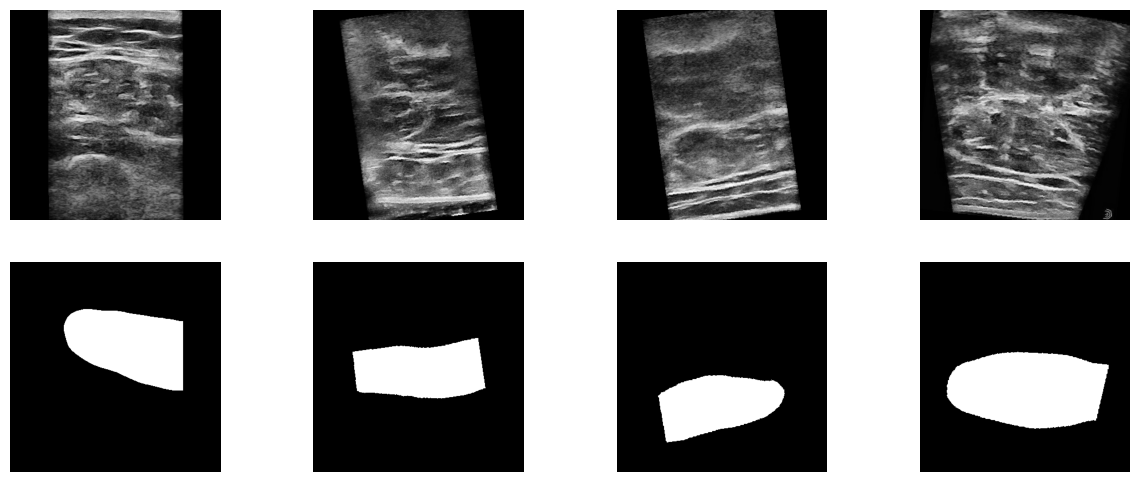

In [15]:
#9. Visualización de muestras
sample = next(iter(train_ds))

fig, ax = plt.subplots(2, 4, figsize=(15, 6))

for i in range(4):
    ax[0, i].imshow(sample[0][i, ..., 0], cmap='gray')
    ax[1, i].imshow(sample[1][i, ..., 0], cmap='gray')
    ax[0, i].axis('off')
    ax[1, i].axis('off')


In [16]:
#10. Guardar los splits para uso posterior
train_df.to_csv("train_split.csv", index=False)
val_df.to_csv("val_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

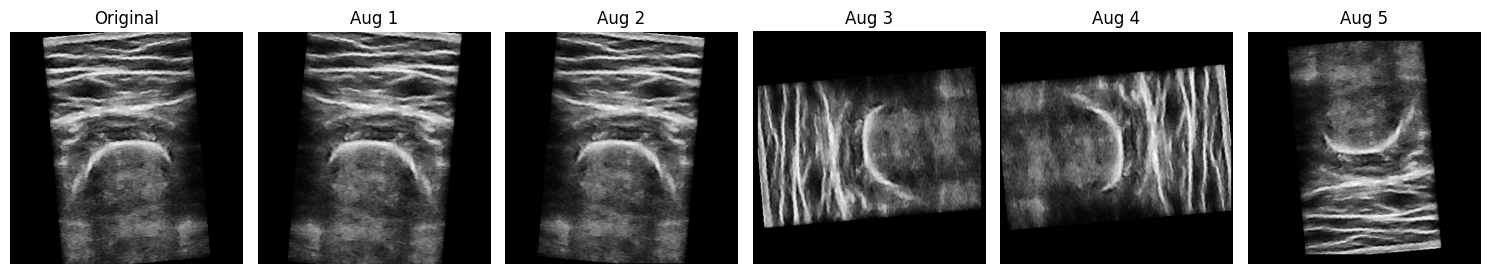

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# Función de data augmentation (misma lógica que en entrenamiento)
# ============================================================
def augment_image(img):
    # Rotación ligera
    img = tf.image.rot90(img, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    
    # Flip horizontal
    img = tf.image.random_flip_left_right(img)
    
    # Zoom ligero
    zoom = tf.random.uniform([], 0.9, 1.1)
    h, w = img.shape[0], img.shape[1]
    img = tf.image.resize(img, [int(h * zoom), int(w * zoom)])
    img = tf.image.resize_with_crop_or_pad(img, h, w)
    
    # Variación de contraste
    img = tf.image.random_contrast(img, 0.8, 1.2)
    
    return img


# ============================================================
# Seleccionar una imagen del dataset
# ============================================================
sample_batch = next(iter(train_ds.take(1)))
sample_img = sample_batch[0][0]  # primera imagen del batch

# ============================================================
# Generar versiones aumentadas
# ============================================================
augmented_imgs = [augment_image(sample_img) for _ in range(5)]

# ============================================================
# Visualización
# ============================================================
plt.figure(figsize=(15, 4))

# Imagen original
plt.subplot(1, 6, 1)
plt.imshow(sample_img[..., 0], cmap="gray")
plt.title("Original")
plt.axis("off")

# Imágenes aumentadas
for i, aug in enumerate(augmented_imgs):
    plt.subplot(1, 6, i + 2)
    plt.imshow(aug[..., 0], cmap="gray")
    plt.title(f"Aug {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()